# Dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Iterative Imputer & Random Forest
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

np.set_printoptions(suppress=True)

# Importing Data

In [3]:
raw_data = pd.read_csv('city_day.csv')

In [4]:
raw_data.head(5)

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


# Data Preprocessing

- Drop AQI_Bucket, not needed for this task
- Drop any rows missing AQI values from simplicity

In [5]:
# Creating dataset from raw data, dropping AQI Bucket
data = raw_data.drop(['AQI_Bucket'], axis=1)

# Dropping rows with missing AQI values
data = data.dropna(subset=['AQI'])

# Convert the date to correct format
data['Date'] = pd.to_datetime(data['Date'])

- Reduce the data to 3 cities to reduce geographical variation: Jaipur, Amritsar, Thiruvananthapuram

In [6]:
regions = ['Amritsar', 'Amaravati', 'Jaipur']
data = data[data['City'].isin(regions)]

# Reset Index
data = data.reset_index(drop=True)

In [7]:
# Data summaries 
np.round(data.describe(),3)

,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,3061,2971.000,3031.000,3006.000,3049.000,2727.000,3045.000,2979.000,2921.000,2976.000,2872.000,2855.000,1617.000,3061.000
mean,2019-01-04 22:02:23.482522112,50.159,107.412,13.281,24.375,30.779,17.991,0.665,11.003,35.744,2.194,4.145,4.885,118.074
min,2017-02-28 00:00:00,2.850,0.420,0.250,0.010,0.860,0.060,0.000,0.710,0.240,0.000,0.000,0.000,20.000
25%,2018-04-13 00:00:00,28.375,62.905,4.880,11.640,15.945,9.720,0.440,7.210,21.210,0.280,1.100,0.150,74.000
50%,2019-01-16 00:00:00,43.630,97.700,10.400,18.960,26.780,14.270,0.660,10.250,31.420,1.130,2.240,2.000,104.000
75%,2019-10-17 00:00:00,63.585,138.735,16.555,32.030,39.130,23.070,0.860,13.250,46.240,2.850,5.515,8.130,143.000
max,2020-07-01 00:00:00,868.660,917.080,103.440,237.270,150.960,129.460,3.830,67.260,172.280,53.890,76.320,137.450,869.000
std,NaN,35.894,62.526,12.981,17.878,22.030,12.889,0.440,5.941,20.465,3.328,5.079,8.077,65.766


### Missing Values

In [8]:
# Missing Values
data.isnull().sum()

City          0
Date          0
PM2.5        90
PM10         30
NO           55
NO2          12
NOx         334
NH3          16
CO           82
SO2         140
O3           85
Benzene     189
Toluene     206
Xylene     1444
AQI           0
dtype: int64

- As per EDA, drop Benzene, Toluene, Xylene as these do not directly correlate with AQI and have significant numbers of missing values

In [9]:
# Drop Benzene, Toluene, Xylene from data
data.drop(['Benzene', 'Toluene', 'Xylene'], axis=1, inplace=True)

### Add missing Values using Iterative Imputer package

In [10]:
# Drop the 'City' and 'Date' column, as it's not used for imputation
data_model = data.drop(['City', 'Date'], axis=1)

# Initialize the Iterative Imputer with a RandomForestRegressor
imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=42)

# Apply the imputer to the dataset
df_imputed = pd.DataFrame(imputer.fit_transform(data_model), columns=data_model.columns)

# Display information about missing values after imputation
print(df_imputed.isnull().sum())

# Merge the imputed dataframe and the dataset
data_new = pd.concat([data[['City', 'Date']], df_imputed], axis=1)


PM2.5    0
PM10     0
NO       0
NO2      0
NOx      0
NH3      0
CO       0
SO2      0
O3       0
AQI      0
dtype: int64


/opt/anaconda3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


# Implementation of Weather Data

In [11]:
# Import Datasets
amarvati = pd.read_csv('amarvati.csv')
amritsar = pd.read_csv('amritsar.csv')
jaipur = pd.read_csv('jaipur.csv')

In [12]:
# Convert the 'Date' columns to datetime and remove timezones for consistency
data_new['Date'] = pd.to_datetime(data_new['Date']).dt.tz_localize(None)
amarvati['date'] = pd.to_datetime(amarvati['date']).dt.tz_localize(None)
jaipur['date'] = pd.to_datetime(jaipur['date']).dt.tz_localize(None)
amritsar['date'] = pd.to_datetime(amritsar['date']).dt.tz_localize(None)

# Rename the 'date' columns to 'Date' for consistency
amarvati.rename(columns={'date': 'Date'}, inplace=True)
jaipur.rename(columns={'date': 'Date'}, inplace=True)
amritsar.rename(columns={'date': 'Date'}, inplace=True)

# Add the 'City' column to each weather dataset
amarvati['City'] = 'Amaravati'
jaipur['City'] = 'Jaipur'
amritsar['City'] = 'Amritsar'

In [13]:
# Create a dictionary to map cities to the correct city csv file
city_data = {
    'Amaravati': amarvati,
    'Jaipur': jaipur,
    'Amritsar': amritsar
}

# Initialise empty lists for storing new data
temperature_mean = []
temperature_max = []
humidity_mean = []
humidity_max = []
dew_point_mean = []
dew_point_max = []
precipitation_sum = []
rain_sum = []
cloud_cover_sum = []
wind_speed_10m_mean = []
wind_speed_10m_max = []
wind_speed_100m_mean = []
wind_speed_100m_max = []

# Loop over each row in data_new_df
for index, row in data_new.iterrows():
    city = row['City']
    date = row['Date']
    
    # Check if the city has corresponding weather data
    if city in city_data:
        weather_df = city_data[city]
        # Find the matching row in the city's weather DataFrame
        match = weather_df[weather_df['Date'] == date]
        
        if not match.empty:
            # Append values to the lists if a match is found
            temperature_mean.append(match['temperature_mean'].values[0])
            temperature_max.append(match['temperature_max'].values[0])
            humidity_mean.append(match['humidity_mean'].values[0])
            humidity_max.append(match['humidity_max'].values[0])
            dew_point_mean.append(match['dew_point_mean'].values[0])
            dew_point_max.append(match['dew_point_max'].values[0])
            precipitation_sum.append(match['precipitation_sum'].values[0])
            rain_sum.append(match['rain_sum'].values[0])
            cloud_cover_sum.append(match['cloud_cover_sum'].values[0])
            wind_speed_10m_mean.append(match['wind_speed_10m_mean'].values[0])
            wind_speed_10m_max.append(match['wind_speed_10m_max'].values[0])
            wind_speed_100m_mean.append(match['wind_speed_100m_mean'].values[0])
            wind_speed_100m_max.append(match['wind_speed_100m_max'].values[0])
        else:
            # Append NaN if no match is found
            temperature_mean.append(float('nan'))
            temperature_max.append(float('nan'))
            humidity_mean.append(float('nan'))
            humidity_max.append(float('nan'))
            dew_point_mean.append(float('nan'))
            dew_point_max.append(float('nan'))
            precipitation_sum.append(float('nan'))
            rain_sum.append(float('nan'))
            cloud_cover_sum.append(float('nan'))
            wind_speed_10m_mean.append(float('nan'))
            wind_speed_10m_max.append(float('nan'))
            wind_speed_100m_mean.append(float('nan'))
            wind_speed_100m_max.append(float('nan'))
    else:
        # Append NaN if no matching city is found
        temperature_mean.append(float('nan'))
        temperature_max.append(float('nan'))
        humidity_mean.append(float('nan'))
        humidity_max.append(float('nan'))
        dew_point_mean.append(float('nan'))
        dew_point_max.append(float('nan'))
        precipitation_sum.append(float('nan'))
        rain_sum.append(float('nan'))
        cloud_cover_sum.append(float('nan'))
        wind_speed_10m_mean.append(float('nan'))
        wind_speed_10m_max.append(float('nan'))
        wind_speed_100m_mean.append(float('nan'))
        wind_speed_100m_max.append(float('nan'))

# Add the new data to the DataFrame
data_new['temperature_mean'] = temperature_mean
data_new['temperature_max'] = temperature_max
data_new['humidity_mean'] = humidity_mean
data_new['humidity_max'] = humidity_max
data_new['dew_point_mean'] = dew_point_mean
data_new['dew_point_max'] = dew_point_max
data_new['precipitation_sum'] = precipitation_sum
data_new['rain_sum'] = rain_sum
data_new['cloud_cover_sum'] = cloud_cover_sum
data_new['wind_speed_10m_mean'] = wind_speed_10m_mean
data_new['wind_speed_10m_max'] = wind_speed_10m_max
data_new['wind_speed_100m_mean'] = wind_speed_100m_mean
data_new['wind_speed_100m_max'] = wind_speed_100m_max

data_new.head(5)

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,...,humidity_max,dew_point_mean,dew_point_max,precipitation_sum,rain_sum,cloud_cover_sum,wind_speed_10m_mean,wind_speed_10m_max,wind_speed_100m_mean,wind_speed_100m_max
0,Amaravati,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,...,89.346016,19.013000,21.263000,0.0,0.0,819.000009,9.180352,16.808570,15.935398,27.248455
1,Amaravati,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,...,95.198590,18.248417,21.063000,0.0,0.0,532.800023,7.759277,11.988594,14.097954,22.183128
2,Amaravati,2017-11-27,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,...,97.275760,18.960917,21.463001,0.0,0.0,618.900014,6.287076,9.085988,11.361810,17.418196
3,Amaravati,2017-11-28,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,...,94.871315,17.425500,21.013000,0.0,0.0,378.000013,7.019016,13.684735,13.233190,25.630886
4,Amaravati,2017-11-29,72.47,114.84,5.23,23.20,16.59,12.25,0.16,10.55,...,96.376900,17.617167,20.663000,0.0,0.0,189.000007,10.355873,14.186923,18.022025,23.904108


# Feature Selection

Applying Ridge & Lasso Regression to examine features

## Ridge Regression:

In [14]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [15]:
# Select features and target
X = data_new[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'temperature_mean', 'temperature_max', 'humidity_mean', 'humidity_max', 'dew_point_mean', 'dew_point_max', 'precipitation_sum', 'rain_sum', 'cloud_cover_sum', 'wind_speed_10m_mean', 'wind_speed_10m_max', 'wind_speed_100m_mean', 'wind_speed_100m_max']]
y = data_new['AQI'] 

In [16]:
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardise both sets of data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initiate Ridge Regression
ridge = Ridge(alpha=1) 

# Fit the model
ridge.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = ridge.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r_squared = ridge.score(X_test_scaled, y_test)
print(f"R-squared: {r_squared}")

# Print Coefficients as table
feature_names = X.columns
coefficients = np.round(ridge.coef_,4)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(coef_df)

ridge_cv = cross_val_score(ridge, X, y, cv=5, scoring='neg_mean_squared_error')
                           
# Output the results (MSE for each fold)
print("Cross-validated MSE (for each fold):", -ridge_cv)

# Mean of the cross-validation scores
print("Average MSE:", -ridge_cv.mean())

Mean Squared Error: 714.9840651051625
R-squared: 0.8103152349664138
                 Feature  Coefficient
0                  PM2.5      18.9150
1                   PM10      42.7939
2                     NO       3.5008
3                    NO2       4.7927
4                    NOx      -2.8811
5                    NH3      -2.1164
6                     CO       3.4449
7                    SO2       0.0638
8                     O3       6.3955
9       temperature_mean       0.6220
10       temperature_max       0.2032
11         humidity_mean       2.2872
12          humidity_max       1.8866
13        dew_point_mean       3.7280
14         dew_point_max      -5.6105
15     precipitation_sum      -0.2112
16              rain_sum      -0.2112
17       cloud_cover_sum       0.3855
18   wind_speed_10m_mean       1.9871
19    wind_speed_10m_max      -1.9092
20  wind_speed_100m_mean       0.2193
21   wind_speed_100m_max       1.5589
Cross-validated MSE (for each fold): [ 786.33793202 2124.8

### Alpha Tuning

In [17]:
from sklearn.model_selection import GridSearchCV

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the alpha values to test for tuning
alpha_values = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

# Initiate Ridge Regression and GridSearchCV
ridge = Ridge()

# Use GridSearchCV to tune alpha
ridge_cv = GridSearchCV(ridge, alpha_values, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_scaled, y_train)

# Best alpha value
best_alpha = ridge_cv.best_params_['alpha']
print(f"Best alpha for Ridge: {best_alpha}")

# Use the best alpha to fit the model again
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = ridge_best.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r_squared = ridge_best.score(X_test_scaled, y_test)
print(f"R-squared: {r_squared}")

# Print Coefficients as table
feature_names = X.columns
coefficients = np.round(ridge_best.coef_, 4)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(coef_df)

Best alpha for Ridge: 100
Mean Squared Error: 707.5063596444817
R-squared: 0.8122990649180518
                 Feature  Coefficient
0                  PM2.5      19.4298
1                   PM10      40.2532
2                     NO       2.6076
3                    NO2       3.9990
4                    NOx      -0.8127
5                    NH3      -1.8339
6                     CO       3.5512
7                    SO2       0.0501
8                     O3       6.3836
9       temperature_mean      -0.1646
10       temperature_max      -0.2618
11         humidity_mean       1.5364
12          humidity_max       1.7149
13        dew_point_mean       1.5337
14         dew_point_max      -2.2828
15     precipitation_sum      -0.1498
16              rain_sum      -0.1498
17       cloud_cover_sum       0.1020
18   wind_speed_10m_mean       1.1818
19    wind_speed_10m_max      -1.1572
20  wind_speed_100m_mean       0.6552
21   wind_speed_100m_max       0.9426


## Lasso Regression:

In [18]:
from sklearn.linear_model import Lasso

# Using majority of the same code as above:
lasso = Lasso(alpha=0.1)

# Fit the model
lasso.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = lasso.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r_squared = lasso.score(X_test_scaled, y_test)
print(f"R-squared: {r_squared}")

# Print Coefficients as table
feature_names = X.columns
coefficients = np.round(lasso.coef_,4)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(coef_df)

lasso_cv = cross_val_score(lasso, X, y, cv=5, scoring='neg_mean_squared_error')
                           
# Output the results (MSE for each fold)
print("Cross-validated MSE (for each fold):", -lasso_cv)

# Mean of the cross-validation scores
print("Average MSE:", -lasso_cv.mean())

Mean Squared Error: 712.6043422395005
R-squared: 0.8109465737537358
                 Feature  Coefficient
0                  PM2.5      18.9113
1                   PM10      42.6902
2                     NO       2.4484
3                    NO2       3.8953
4                    NOx      -1.2241
5                    NH3      -1.9252
6                     CO       3.2912
7                    SO2       0.1100
8                     O3       6.3261
9       temperature_mean      -0.0000
10       temperature_max      -0.0000
11         humidity_mean       2.4026
12          humidity_max       1.3896
13        dew_point_mean       0.0000
14         dew_point_max      -1.2026
15     precipitation_sum      -0.1977
16              rain_sum      -0.0000
17       cloud_cover_sum       0.1910
18   wind_speed_10m_mean       0.3868
19    wind_speed_10m_max      -0.2970
20  wind_speed_100m_mean       1.5359
21   wind_speed_100m_max       0.0899
Cross-validated MSE (for each fold): [ 782.4671989  2127.8

### Alpha Tuning

In [19]:
from sklearn.model_selection import GridSearchCV

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the alpha values to test for tuning
alpha_values = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

# Initiate Ridge Regression and GridSearchCV
lasso = Lasso()

# Use GridSearchCV to tune alpha
lasso_cv = GridSearchCV(lasso, alpha_values, cv=5, scoring='neg_mean_squared_error')
lasso_cv.fit(X_train_scaled, y_train)

# Best alpha value
best_alpha = lasso_cv.best_params_['alpha']
print(f"Best alpha for Lasso: {best_alpha}")

# Use the best alpha to fit the model again
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = lasso_best.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r_squared = ridge_best.score(X_test_scaled, y_test)
print(f"R-squared: {r_squared}")

# Print Coefficients as table
feature_names = X.columns
coefficients = np.round(lasso_best.coef_, 4)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(coef_df)

Best alpha for Lasso: 1
Mean Squared Error: 707.4552329128535
R-squared: 0.8122990649180518
                 Feature  Coefficient
0                  PM2.5      18.2222
1                   PM10      42.3219
2                     NO       0.4675
3                    NO2       2.4682
4                    NOx       0.0000
5                    NH3      -0.0000
6                     CO       2.8040
7                    SO2       0.0000
8                     O3       5.0187
9       temperature_mean      -0.0000
10       temperature_max      -1.1307
11         humidity_mean       0.0000
12          humidity_max       1.2516
13        dew_point_mean      -0.0000
14         dew_point_max      -0.0000
15     precipitation_sum       0.0000
16              rain_sum       0.0000
17       cloud_cover_sum       0.0000
18   wind_speed_10m_mean       0.0000
19    wind_speed_10m_max       0.0000
20  wind_speed_100m_mean       0.2375
21   wind_speed_100m_max       0.0000


- As PM2.5 particles are included in PM10, we face the issue of multicolinearity. By applying PCA onto these features we can reduce this.

- This improves the Ridge and Lasso Regression models but will sacrifice interpretability

## Principle Component Analysis

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Step 1: Standardize the data
scaler = StandardScaler()
pm_data_scaled = scaler.fit_transform(data_new[['PM2.5', 'PM10']])

# Step 2: Apply PCA to PM2.5 and PM10
pca = PCA(n_components=2)  # Use 2 components because we have 2 features
pm_pca = pca.fit_transform(pm_data_scaled)

# Create a new DataFrame with the principal components
pm_pca_df = pd.DataFrame(pm_pca, columns=['PC1', 'PC2'])

# Explained variance to understand how much information is captured by each component
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance}")

# Keep PC1 and drop both PM2.5 and PM10
X.drop(['PM2.5', 'PM10'], axis=1, inplace=True)

# Add PC1
X.insert(0, 'PC1', pm_pca[:, 0])

Explained Variance Ratio: [0.85243502 0.14756498]


/var/folders/8h/gtndp3dj3pl2vs4brgn9zq9h0000gp/T/ipykernel_41045/408682948.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(['PM2.5', 'PM10'], axis=1, inplace=True)


### Ridge

In [21]:
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardise both sets of data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initiate Ridge Regression
ridge = Ridge(alpha=1.0) 

# Fit the model
ridge.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = ridge.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r_squared = ridge.score(X_test_scaled, y_test)
print(f"R-squared: {r_squared}")

# Print Coefficients as table
feature_names = X.columns
coefficients = np.round(ridge.coef_,4)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(coef_df)

ridge_cv = cross_val_score(ridge, X, y, cv=5, scoring='neg_mean_squared_error')
                           
# Output the results (MSE for each fold)
print("Cross-validated MSE (for each fold):", -ridge_cv)

# Mean of the cross-validation scores
print("Average MSE:", -ridge_cv.mean())

Mean Squared Error: 627.639045852517
R-squared: 0.833487806583594
                 Feature  Coefficient
0                    PC1      55.7805
1                     NO       3.4075
2                    NO2       4.6921
3                    NOx      -1.4450
4                    NH3      -2.5286
5                     CO       4.6348
6                    SO2      -1.3356
7                     O3       7.1264
8       temperature_mean      -5.6342
9        temperature_max       0.8443
10         humidity_mean      -1.5239
11          humidity_max       1.3184
12        dew_point_mean       8.4276
13         dew_point_max      -3.1936
14     precipitation_sum       0.0694
15              rain_sum       0.0694
16       cloud_cover_sum      -0.8226
17   wind_speed_10m_mean       2.5631
18    wind_speed_10m_max      -1.6313
19  wind_speed_100m_mean      -0.9533
20   wind_speed_100m_max       2.4397
Cross-validated MSE (for each fold): [ 667.36647636 1821.97153528 1183.76082792  704.49839319  529

In [22]:
from sklearn.model_selection import GridSearchCV

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the alpha values to test for tuning
alpha_values = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

# Initiate Ridge Regression and GridSearchCV
ridge = Ridge()

# Use GridSearchCV to tune alpha
ridge_cv = GridSearchCV(ridge, alpha_values, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_scaled, y_train)

# Best alpha value
best_alpha = ridge_cv.best_params_['alpha']
print(f"Best alpha for Ridge: {best_alpha}")

# Use the best alpha to fit the model again
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = ridge_best.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r_squared = ridge_best.score(X_test_scaled, y_test)
print(f"R-squared: {r_squared}")

# Print Coefficients as table
feature_names = X.columns
coefficients = np.round(ridge_best.coef_, 4)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(coef_df)

Best alpha for Ridge: 10
Mean Squared Error: 628.3457229751431
R-squared: 0.8333003256445046
                 Feature  Coefficient
0                    PC1      55.4979
1                     NO       3.3376
2                    NO2       4.6172
3                    NOx      -1.2160
4                    NH3      -2.4994
5                     CO       4.6410
6                    SO2      -1.3166
7                     O3       7.1393
8       temperature_mean      -3.1450
9        temperature_max       0.1447
10         humidity_mean      -0.2219
11          humidity_max       1.4131
12        dew_point_mean       6.0820
13         dew_point_max      -2.8225
14     precipitation_sum       0.0453
15              rain_sum       0.0453
16       cloud_cover_sum      -0.9763
17   wind_speed_10m_mean       2.4141
18    wind_speed_10m_max      -1.4867
19  wind_speed_100m_mean      -0.8003
20   wind_speed_100m_max       2.3033


### Lasso

In [23]:
# Using majority of the same code as above:
lasso = Lasso(alpha=0.1)

# Fit the model
lasso.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = lasso.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r_squared = lasso.score(X_test_scaled, y_test)
print(f"R-squared: {r_squared}")

# Print Coefficients as table
feature_names = X.columns
coefficients = np.round(lasso.coef_,4)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(coef_df)

lasso_cv = cross_val_score(lasso, X, y, cv=5, scoring='neg_mean_squared_error')
                           
# Output the results (MSE for each fold)
print("Cross-validated MSE (for each fold):", -lasso_cv)

# Mean of the cross-validation scores
print("Average MSE:", -lasso_cv.mean())

Mean Squared Error: 624.6501013099676
R-squared: 0.8342807714494174
                 Feature  Coefficient
0                    PC1      55.7258
1                     NO       2.6294
2                    NO2       3.8792
3                    NOx      -0.0000
4                    NH3      -2.3723
5                     CO       4.4442
6                    SO2      -1.1245
7                     O3       7.0581
8       temperature_mean      -0.0003
9        temperature_max      -0.4294
10         humidity_mean       1.7942
11          humidity_max       1.3648
12        dew_point_mean       0.4041
13         dew_point_max      -0.0000
14     precipitation_sum      -0.0000
15              rain_sum      -0.0000
16       cloud_cover_sum      -0.7275
17   wind_speed_10m_mean       1.2649
18    wind_speed_10m_max      -0.2204
19  wind_speed_100m_mean       0.1180
20   wind_speed_100m_max       1.1279
Cross-validated MSE (for each fold): [ 663.73754117 1824.56938956 1183.74841313  700.40047658  5

In [24]:
from sklearn.model_selection import GridSearchCV

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the alpha values to test for tuning
alpha_values = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

# Initiate Ridge Regression and GridSearchCV
lasso = Lasso()

# Use GridSearchCV to tune alpha
lasso_cv = GridSearchCV(lasso, alpha_values, cv=5, scoring='neg_mean_squared_error')
lasso_cv.fit(X_train_scaled, y_train)

# Best alpha value
best_alpha = lasso_cv.best_params_['alpha']
print(f"Best alpha for Lasso: {best_alpha}")

# Use the best alpha to fit the model again
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = lasso_best.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r_squared = ridge_best.score(X_test_scaled, y_test)
print(f"R-squared: {r_squared}")

# Print Coefficients as table
feature_names = X.columns
coefficients = np.round(lasso_best.coef_, 4)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(coef_df)

Best alpha for Lasso: 0.1
Mean Squared Error: 624.6501013099676
R-squared: 0.8333003256445046
                 Feature  Coefficient
0                    PC1      55.7258
1                     NO       2.6294
2                    NO2       3.8792
3                    NOx      -0.0000
4                    NH3      -2.3723
5                     CO       4.4442
6                    SO2      -1.1245
7                     O3       7.0581
8       temperature_mean      -0.0003
9        temperature_max      -0.4294
10         humidity_mean       1.7942
11          humidity_max       1.3648
12        dew_point_mean       0.4041
13         dew_point_max      -0.0000
14     precipitation_sum      -0.0000
15              rain_sum      -0.0000
16       cloud_cover_sum      -0.7275
17   wind_speed_10m_mean       1.2649
18    wind_speed_10m_max      -0.2204
19  wind_speed_100m_mean       0.1180
20   wind_speed_100m_max       1.1279


- From here we can look to remove x,y and z features

## Feature Removal

In [25]:
# Based off of Ridge & Lasso Regression, we can remove certain components
columns_to_drop = ['NOx', 'temperature_mean', 'dew_point_max', 'precipitation_sum', 'rain_sum', 'wind_speed_100m_mean', 'wind_speed_10m_max', 'temperature_max', 'dew_point_mean'] # Removing all zeroed components & any low coefficient features

# Drop columns on original data
#model_data = data_new.drop(columns_to_drop, axis=1) # This data does not include Principle Component Analysis

# Apply Principle Component to original data and drop columns
model_data = data_new.drop(['PM2.5', 'PM10'], axis=1)
# Add PC1
model_data.insert(2, 'PC1', pm_pca[:, 0])
model_data.drop(columns_to_drop, axis=1, inplace=True)

In [26]:
model_data.to_csv('model_data.csv', index=True)

model_data.head(1)

,City,Date,PC1,NO,NO2,NH3,CO,SO2,O3,AQI,humidity_mean,humidity_max,cloud_cover_sum,wind_speed_10m_mean,wind_speed_100m_max
0,Amaravati,2017-11-25,0.824094,1.44,20.5,10.72,0.12,15.24,127.09,184.0,64.906533,89.346016,819.000009,9.180352,27.248455


# SMOTER for Data Imbalance

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='AQI', ylabel='Count'>

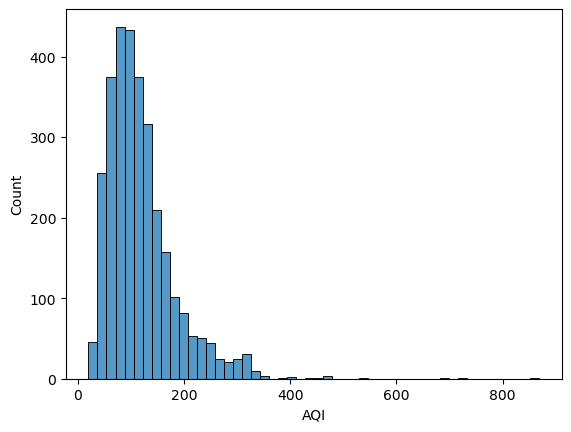

In [27]:
# Distribution of AQI
sns.histplot(model_data['AQI'], bins=50)

- Implement SMOTER after test/train split

# Model Evaluation Without SMOTER

### Metrics for Evaluation:
- RMSE
- MSE
- R-Squared

In [28]:
X = model_data.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data['AQI']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Benchmark (Ordinary Least Squares)

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Initialize the model
linear_model = LinearRegression()

# Fit the model on the data
linear_model.fit(X_train, y_train)

# Make predictions
y_pred = linear_model.predict(X_test)

# Perform cross-validation
ols_cv = cross_val_score(linear_model, X, y, cv=5, scoring='neg_mean_squared_error')
ols_cv_r2 = cross_val_score(linear_model, X, y, cv=5, scoring='r2')

In [30]:
# Evaluate the model performance
ols_mse = mean_squared_error(y_test, y_pred)
ols_rmse = np.sqrt(ols_mse)
ols_r2 = r2_score(y_test, y_pred)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


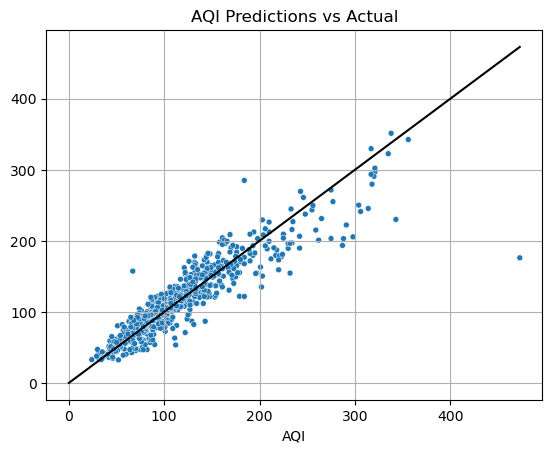

In [31]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

## Random Forest Regressor

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and fit the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)

# Cross Validate
rf_cv = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error')
rf_cv_r2 = cross_val_score(rf, X, y, cv=5, scoring='r2')


In [33]:
# Evaluate Model Performance
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, y_pred_rf)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


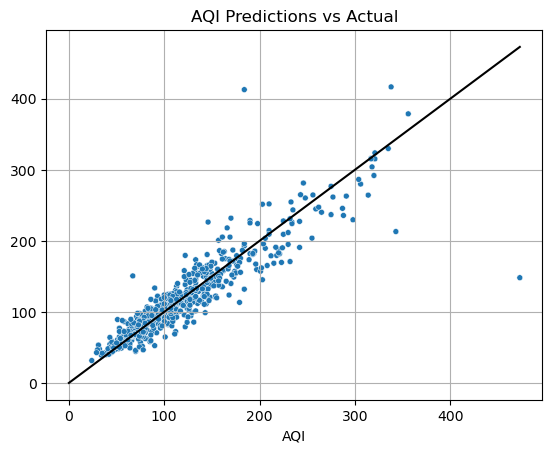

In [34]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_rf, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

### Parameter Tuning using RandomisedSearch

In [35]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV


# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_dist = {
    'n_estimators': randint(50, 200),  # Random number of trees between 50 and 200
    'max_depth': randint(5, 20),  # Random depth between 5 and 20
    'min_samples_split': randint(2, 10),  # Random min samples for split between 2 and 10
    'min_samples_leaf': randint(1, 10),  # Random min samples at leaf between 1 and 10
    'max_features': ['sqrt', 'log2', None]  # Replace 'auto' with 'sqrt', 'log2', or None
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, 
                                   n_iter=20, cv=5, scoring='neg_mean_squared_error', 
                                   random_state=42, n_jobs=-1)

# Fit the random search model
random_search.fit(X_train, y_train)

# Access cross val results
rf_results = random_search.cv_results_

# Get the best parameters
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

# Use the best model to make predictions
best_rf = random_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)


Best parameters found: {'max_depth': 19, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 84}


In [36]:
# Evaluate the best model
rf_mse_best = mean_squared_error(y_test, y_pred_best_rf)
rf_rmse_best = np.sqrt(rf_mse_best)
rf_r2_best = r2_score(y_test, y_pred_best_rf)

In [37]:
# Cross validation for comparison
rf_cv_best = cross_val_score(best_rf, X, y, cv=5, scoring='neg_mean_squared_error')
rf_cv_r2_best = cross_val_score(best_rf, X, y, cv=5, scoring='r2')

print(f"Average MSE {-np.mean(rf_cv_best)}\n"
      f"Cross Validation R-Square {np.mean(rf_cv_r2_best)}")

Average MSE 900.6354238372521
Cross Validation R-Square 0.7925493580052512


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


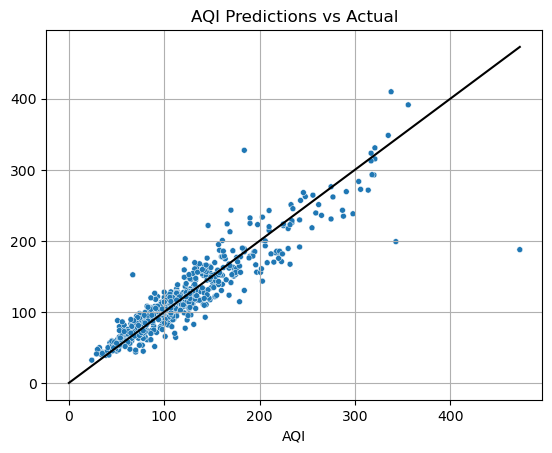

In [38]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_best_rf, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

## Support Vector Regression

In [39]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Standardize the data (SVR requires standardized input)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and fit the Support Vector Regression model
svr = SVR(kernel='rbf')  # Using RBF kernel for non-linear relationships
svr.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_svr = svr.predict(X_test_scaled)

# Cross Validate
svr_cv = cross_val_score(svr, X, y, cv=5, scoring='neg_mean_squared_error')
svr_cv_r2 = cross_val_score(svr, X, y, cv=5, scoring='r2')


In [40]:
# Evaluate Model
svr_mse = mean_squared_error(y_test, y_pred_svr)
svr_rmse = np.sqrt(svr_mse)
svr_r2 = r2_score(y_test, y_pred_svr)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


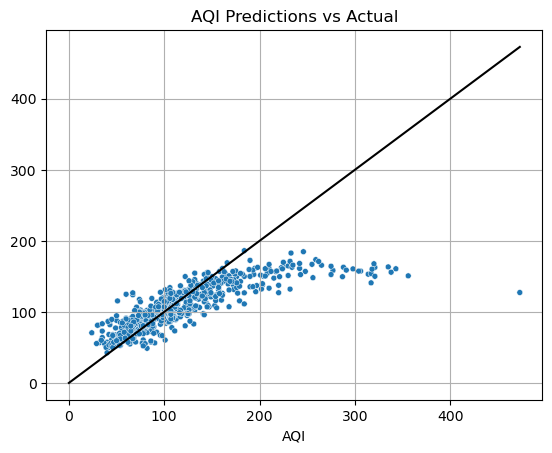

In [41]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_svr, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

### Parameter Tuning using RandomisedSearch

In [42]:
from scipy.stats import uniform

# Standardize the data (SVR requires standardized input)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Support Vector Regressor (SVR)
svr = SVR()

# Define the hyperparameter grid
param_dist = {
    'C': uniform(0.1, 100),  # Regularization parameter between 0.1 and 100
    'epsilon': uniform(0.01, 1),  # Epsilon value for margin
    'gamma': ['scale', 'auto'],  # Gamma parameter for the RBF kernel
    'kernel': ['rbf', 'linear']  # Kernel options
}

# Use RandomizedSearchCV for tuning
random_search_svr = RandomizedSearchCV(svr, param_distributions=param_dist, 
                                       n_iter=20, cv=5, scoring='neg_mean_squared_error', 
                                       random_state=42, n_jobs=-1)

# Fit the random search model
random_search_svr.fit(X_train_scaled, y_train)

# Access cross validation results
svr_results = random_search_svr.cv_results_

# Get the best parameters
best_params_svr = random_search_svr.best_params_
print(f"Best parameters found: {best_params_svr}")

# Use the best model to make predictions
best_svr = random_search_svr.best_estimator_
y_pred_best_svr = best_svr.predict(X_test_scaled)



Best parameters found: {'C': 5.908361216819946, 'epsilon': 0.8761761457749352, 'gamma': 'auto', 'kernel': 'linear'}


In [43]:
# Evaluate the best model
svr_mse_best = mean_squared_error(y_test, y_pred_best_svr)
svr_rmse_best = np.sqrt(svr_mse_best)
svr_r2_best = r2_score(y_test, y_pred_best_svr)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


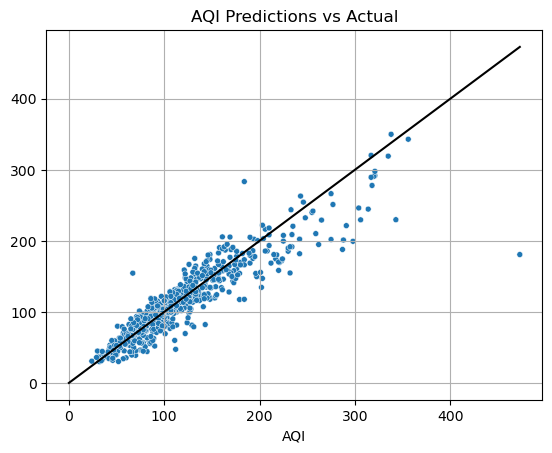

In [44]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_best_svr, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

## XGBoost 

In [45]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the XGBoost Regressor with default or manually chosen parameters
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Perform cross-validation for MSE and R-squared
xgb_cv_mse = cross_val_score(xgb_model, X, y, cv=5, scoring='neg_mean_squared_error')
xgb_cv_r2 = cross_val_score(xgb_model, X, y, cv=5, scoring='r2')



In [46]:
# Evaluate the Model
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, y_pred_xgb)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


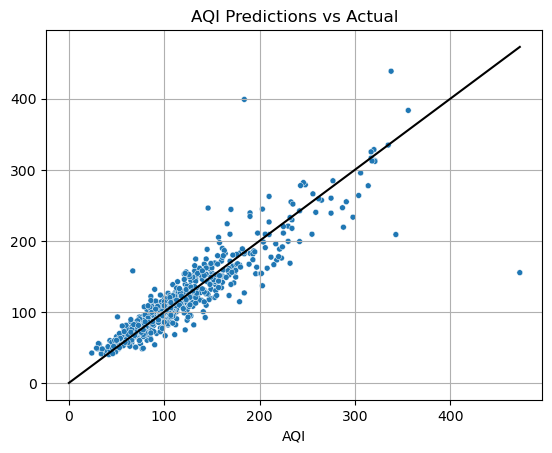

In [47]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_xgb, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

### Parameter Tuning using RandomisedSearch

In [48]:
import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the XGBoost Regressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Define the hyperparameter grid
param_dist = {
    'n_estimators': randint(50, 200),  # Number of trees (estimators)
    'learning_rate': uniform(0.01, 0.3),  # Learning rate (eta)
    'max_depth': randint(3, 10),  # Depth of trees
    'subsample': uniform(0.5, 0.5),  # Subsampling of rows
    'colsample_bytree': uniform(0.5, 0.5),  # Subsampling of columns
    'reg_alpha': uniform(0, 0.1),  # L1 regularization (alpha)
    'reg_lambda': uniform(0.1, 1.0),  # L2 regularization (lambda)
}

# Use RandomizedSearchCV for tuning
random_search_xgb = RandomizedSearchCV(xgb_model, param_distributions=param_dist, 
                                       n_iter=20, cv=5, scoring='neg_mean_squared_error', 
                                       random_state=42, n_jobs=-1)

# Fit the random search model
random_search_xgb.fit(X_train, y_train)

# Access cross validation results
xgb_results = random_search_xgb.cv_results_

# Get the best parameters
best_params_xgb = random_search_xgb.best_params_
print(f"Best parameters found: {best_params_xgb}")

# Use the best model to make predictions
best_xgb = random_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)

Best parameters found: {'colsample_bytree': 0.6558555380447055, 'learning_rate': 0.16602040635334325, 'max_depth': 4, 'n_estimators': 53, 'reg_alpha': 0.018485445552552705, 'reg_lambda': 1.0695846277645586, 'subsample': 0.8875664116805573}


In [49]:
# Evaluate the Model
xgb_mse_best = mean_squared_error(y_test, y_pred_best_xgb)
xgb_rmse_best = np.sqrt(xgb_mse_best)
xgb_r2_best = r2_score(y_test, y_pred_best_xgb)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


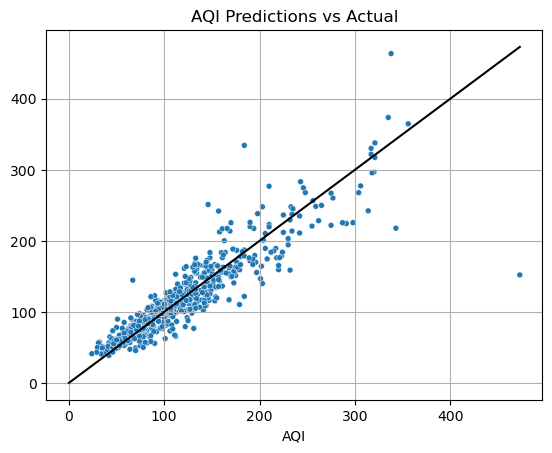

In [50]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_best_xgb, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

## Stacked Neural Network + XGBoost

In [51]:
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import StackingRegressor

# Initialize XGBoost and Neural Network as base learners
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
nn_model = MLPRegressor(hidden_layer_sizes=(50,), activation='relu', solver='adam', max_iter=5000, random_state=42)

# Create the stacking model using Linear Regression as the meta-model
stacked_model = StackingRegressor(
    estimators=[('xgb', xgb_model), ('nn', nn_model)],
    final_estimator=LinearRegression()
)

# Fit the stacked model
stacked_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred_stacked = stacked_model.predict(X_test)

hybrid_cv = cross_val_score(stacked_model, X, y, cv=5, scoring='neg_mean_squared_error')
hybrid_cv_r2 = cross_val_score(stacked_model, X, y, cv=5, scoring='r2')


In [52]:
# Evaluate the Model
stacked_mse = mean_squared_error(y_test, y_pred_stacked)
stacked_rmse = np.sqrt(stacked_mse)
stacked_r2 = r2_score(y_test, y_pred_stacked)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


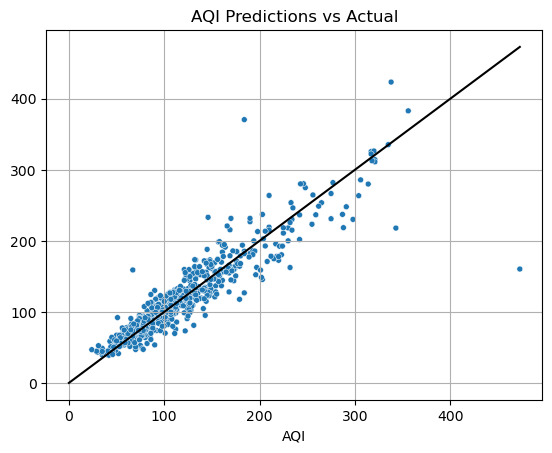

In [53]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_stacked, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

### Parameter Tuning using RandomSearch

In [54]:
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import uniform, randint

# Initialize base models
xgb_model = xgb.XGBRegressor(random_state=42)
nn_model = MLPRegressor(max_iter=5000, random_state=42, verbose=False)

# Define the stacking model
stacked_model = StackingRegressor(
    estimators=[('xgb', xgb_model), ('nn', nn_model)],
    final_estimator=LinearRegression()
)

# Define hyperparameter grid for RandomizedSearchCV
param_grid = {
    'xgb__n_estimators': randint(50, 200),
    'xgb__learning_rate': uniform(0.01, 0.3),
    'xgb__max_depth': randint(3, 10),
    'xgb__subsample': uniform(0.5, 0.5),  # Generates values strictly between 0.5 and 1.0
    'xgb__colsample_bytree': uniform(0.5, 0.5),  # Same, strictly between 0.5 and 1.0
    
    'nn__hidden_layer_sizes': [(50,), (100,), (100, 100)],
    'nn__activation': ['relu'],
    'nn__alpha': uniform(0.0001, 0.01),  # Reasonable regularization range
    'nn__solver': ['adam']
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=stacked_model, 
                                   param_distributions=param_grid, 
                                   n_iter=20, 
                                   cv=5, 
                                   scoring='neg_mean_squared_error',
                                   random_state=42, 
                                   n_jobs=1,  # No parallel jobs
                                   error_score='raise')  # Raise errors

# Fit the random search model
random_search.fit(X_train, y_train)

# Access cross-validation results
stacked_restults = random_search.cv_results_

# Get the best parameters and best model
best_stacked_model = random_search.best_estimator_
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

# Make predictions and evaluate the tuned stacked model
y_pred_best_stacked = best_stacked_model.predict(X_test)


Best parameters found: {'nn__activation': 'relu', 'nn__alpha': 0.006475574713552132, 'nn__hidden_layer_sizes': (100, 100), 'nn__solver': 'adam', 'xgb__colsample_bytree': 0.7806217129238506, 'xgb__learning_rate': 0.12487806242613694, 'xgb__max_depth': 9, 'xgb__n_estimators': 180, 'xgb__subsample': 0.8803925243084487}


In [55]:
# Evaluate the model
stacked_mse_best = mean_squared_error(y_test, y_pred_best_stacked)
stacked_rmse_best = np.sqrt(stacked_mse_best)
stacked_r2_best = r2_score(y_test, y_pred_best_stacked)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


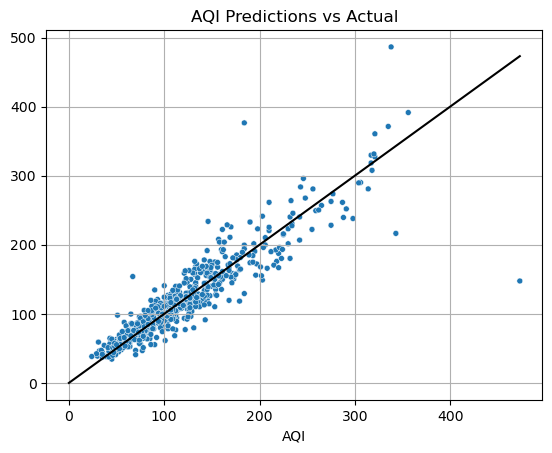

In [56]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_best_stacked, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

# Model Comparisons

In [57]:
from scipy.stats import f_oneway

rf_results_mse = rf_results['mean_test_score']
svr_results_mse = svr_results['mean_test_score']
xgb_results_mse = xgb_results['mean_test_score']
stacked_restults_mse = stacked_restults['mean_test_score']

# Perform ANOVA test
f_statistic, p_value = f_oneway(rf_results_mse, svr_results_mse, xgb_results_mse, stacked_restults_mse)

# Output the results
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

# Interpretation of ANOVA test result
if p_value < 0.05:
    print("There is a statistically significant difference between the models.")
else:
    print("No statistically significant difference between the models.")


F-statistic: 25.513118680393326
P-value: 1.60206144402303e-11
There is a statistically significant difference between the models.


In [58]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Example MSE data for three models
# Replace with your cross-validated MSE data
mse_data = np.concatenate([rf_results_mse, svr_results_mse, xgb_results_mse, stacked_restults_mse])

# Corresponding labels for the models
model_labels = (['Random Forest'] * len(rf_results_mse)) + (['SVG'] * len(svr_results_mse)) + (['XGBoost'] * len(xgb_results_mse) + (['Hybrid Model'] * len(stacked_restults_mse)))

# Create a DataFrame to hold the MSE values and corresponding model labels
df = pd.DataFrame({'MSE': mse_data, 'Model': model_labels})

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df['MSE'], groups=df['Model'], alpha=0.05)

# Display the test results
print(tukey)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
    group1        group2     meandiff p-adj    lower     upper   reject
-----------------------------------------------------------------------
 Hybrid Model Random Forest -175.3266    0.0 -249.6724 -100.9809   True
 Hybrid Model           SVG -142.5927    0.0 -216.9384  -68.2469   True
 Hybrid Model       XGBoost   27.0668 0.7745   -47.279  101.4125  False
Random Forest           SVG   32.7339 0.6558  -41.6118  107.0797  False
Random Forest       XGBoost  202.3934    0.0  128.0477  276.7392   True
          SVG       XGBoost  169.6595    0.0   95.3137  244.0052   True
-----------------------------------------------------------------------


In [59]:
# Dataframe for Metric Comparison without SMOTER

models = ['OLS', 'Random Forest', 'SVR', 'XGB', 'XGB + NN']
mse = [ols_mse, rf_mse_best, svr_mse_best, xgb_mse_best, stacked_mse_best]
rmse = [ols_rmse, rf_rmse_best, svr_rmse_best, xgb_rmse_best, stacked_rmse_best]
r2 = [ols_r2, rf_r2_best, svr_r2_best, xgb_r2_best, stacked_r2_best]

# Create the DataFrame
df_results = pd.DataFrame({
    'Model': models,
    'MSE': mse,
    'RMSE': rmse,
    'R²': r2
}, index = models)

# Display the DataFrame
df_results

,Model,MSE,RMSE,R²
OLS,OLS,626.322563,25.026437,0.833837
Random Forest,Random Forest,558.277437,23.627895,0.851889
SVR,SVR,633.815713,25.175697,0.831849
XGB,XGB,685.956076,26.190763,0.818016
XGB + NN,XGB + NN,679.277412,26.062951,0.819788


## Cross Validation Comparison

In [74]:
X = model_data.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data['AQI']

# Hybrid
stacked_mse_cv = -cross_val_score(best_stacked_model, X, y, cv=5, scoring='neg_mean_squared_error')
stacked_r2_cv = cross_val_score(best_stacked_model, X, y, cv=5, scoring='r2')

# RF
rf_mse_cv = -cross_val_score(best_rf, X, y, cv=5, scoring='neg_mean_squared_error')
rf_r2_cv = cross_val_score(best_rf, X, y, cv=5, scoring='r2')

# SVR
svr_r2_cv = cross_val_score(best_svr, X, y, cv=5, scoring='r2', n_jobs=-1)
svr_mse_cv = -cross_val_score(best_svr, X, y, cv=5, scoring='neg_mean_squared_error')

# XGBoost
xgb_r2_cv = cross_val_score(best_xgb, X, y, cv=5, scoring='r2')
xgb_mse_cv = -cross_val_score(best_xgb, X, y, cv=5, scoring='neg_mean_squared_error')

# Average MSE
avg_mse = [np.mean(stacked_mse_cv),np.mean(rf_mse_cv),np.mean(svr_mse_cv),np.mean(xgb_mse_cv)]

# Average RMSE
avg_rmse = [np.mean(np.sqrt(stacked_mse_cv)),np.mean(np.sqrt(rf_mse_cv)),np.mean(np.sqrt(svr_mse_cv)),np.mean(np.sqrt(xgb_mse_cv))]

# Average R2
avg_r2 = [np.mean(stacked_r2_cv),np.mean(rf_r2_cv),np.mean(svr_r2_cv),np.mean(xgb_r2_cv)]

In [77]:
# CV dataframe

cv_models = ['Random Forest', 'SVR', 'XGB', 'XGB + NN']

cv_results = pd.DataFrame({
    'Models': cv_models,
    'MSE': avg_mse,
    'RMSE': avg_rmse,
    'R²': avg_r2
})

cv_results

,Models,MSE,RMSE,R²
0,Random Forest,931.085902,29.704968,0.785818
1,SVR,900.635424,29.130847,0.792549
2,XGB,879.165371,28.938207,0.796085
3,XGB + NN,893.867957,29.151006,0.790344


# Model Evaluation with SMOTER

- Below needs to be rerun until it works

In [ ]:
import smogn

X = model_data.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data['AQI']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Resample using higher values K on training set
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

train_resampled = pd.concat([X_train, y_train], axis=1)
train_resampled = smogn.smoter(train_resampled, y='AQI', k=5, samp_method='extreme')

# Split the resampled data back into features and target
X_resampled = train_resampled.drop(columns='AQI', axis=1)
y_resampled = train_resampled['AQI']

r_index: 100%|##########| 254/254 [00:00<00:00, 2893.30it/s]


## Benchmark (Ordinary Least Squares)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Initialize the model
linear_model = LinearRegression()

# Fit the model on the data
linear_model.fit(X_resampled, y_resampled)

# Make predictions
y_pred = linear_model.predict(X_test)

# Perform cross-validation
ols_cv_smoter = cross_val_score(linear_model, X, y, cv=5, scoring='neg_mean_squared_error')
ols_cv_r2_smoter = cross_val_score(linear_model, X, y, cv=5, scoring='r2')

In [ ]:
# Evaluate the model performance
ols_mse_smoter = mean_squared_error(y_test, y_pred)
ols_rmse_smoter = np.sqrt(ols_mse_smoter)
ols_r2_smoter = r2_score(y_test, y_pred)


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


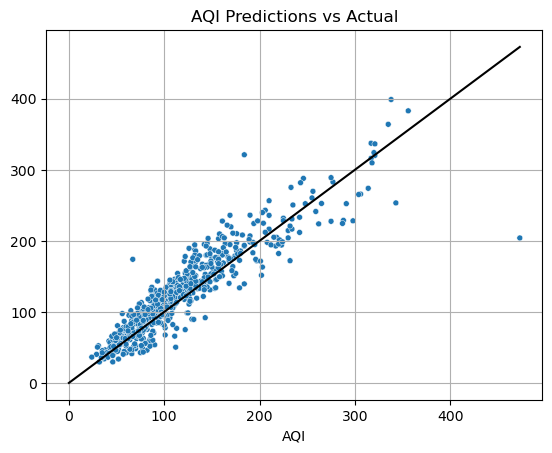

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

## Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and fit the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_resampled, y_resampled)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)

# Cross Validate
rf_cv = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error')
rf_cv_r2 = cross_val_score(rf, X, y, cv=5, scoring='r2')



In [ ]:
# Evaluate Model Performance
rf_mse_smoter = mean_squared_error(y_test, y_pred_rf)
rf_rmse_smoter = np.sqrt(rf_mse_smoter)
rf_r2_smoter = r2_score(y_test, y_pred_rf)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


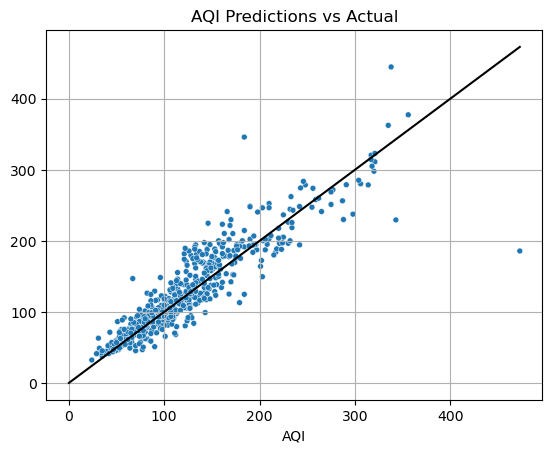

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_rf, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

### Parameter Tuning using RandomisedSearch

In [ ]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_dist = {
    'n_estimators': randint(50, 200),  # Random number of trees between 50 and 200
    'max_depth': randint(5, 20),  # Random depth between 5 and 20
    'min_samples_split': randint(2, 10),  # Random min samples for split between 2 and 10
    'min_samples_leaf': randint(1, 10),  # Random min samples at leaf between 1 and 10
    'max_features': ['sqrt', 'log2', None]  # Replace 'auto' with 'sqrt', 'log2', or None
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, 
                                   n_iter=20, cv=5, scoring='neg_mean_squared_error', 
                                   random_state=42, n_jobs=-1)

# Fit the random search model
random_search.fit(X_resampled, y_resampled)

# Access cross val results
rf_results_smoter = random_search.cv_results_

# Get the best parameters
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

# Use the best model to make predictions
best_rf = random_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

Best parameters found: {'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 120}


In [ ]:
# Evaluate the best model
rf_mse_best_smoter = mean_squared_error(y_test, y_pred_best_rf)
rf_rmse_best_smoter = np.sqrt(rf_mse_best_smoter)
rf_r2_best_smoter = r2_score(y_test, y_pred_best_rf)

In [ ]:
# Cross validation for comparison
rf_cv_best = cross_val_score(best_rf, X, y, cv=5, scoring='neg_mean_squared_error')
rf_cv_r2_best = cross_val_score(best_rf, X, y, cv=5, scoring='r2')

print(f"Average MSE {-np.mean(rf_cv_best)}\n"
      f"Cross Validation R-Square {np.mean(rf_cv_r2_best)}")

Average MSE 1116.4201612710003
Cross Validation R-Square 0.7418064493743833


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


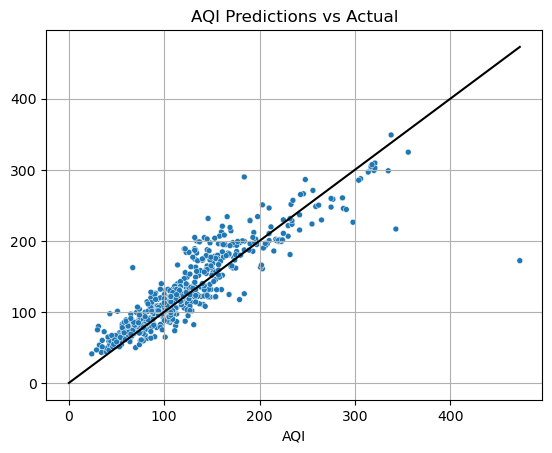

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_best_rf, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

## Support Vector Regression

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Standardize the data (SVR requires standardized input)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# Initialize and fit the Support Vector Regression model
svr = SVR(kernel='rbf')  # Using RBF kernel for non-linear relationships
svr.fit(X_train_scaled, y_resampled)

# Predict and evaluate
y_pred_svr = svr.predict(X_test_scaled)

# Cross Validate
svr_cv = cross_val_score(svr, X, y, cv=5, scoring='neg_mean_squared_error')
svr_cv_r2 = cross_val_score(svr, X, y, cv=5, scoring='r2')

In [ ]:
# Evaluate Model
svr_mse_smoter = mean_squared_error(y_test, y_pred_svr)
svr_rmse_smoter = np.sqrt(svr_mse_smoter)
svr_r2_smoter = r2_score(y_test, y_pred_svr)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


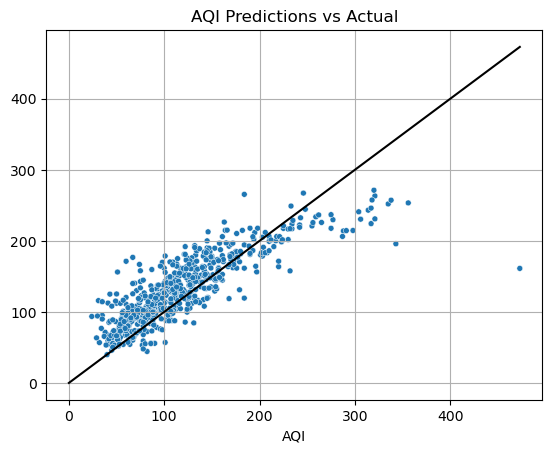

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_svr, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

### Parameter Tuning using RandomisedSearch

In [ ]:
from scipy.stats import uniform

# Standardize the data (SVR requires standardized input)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# Initialize the Support Vector Regressor (SVR)
svr = SVR()

# Define the hyperparameter grid
param_dist = {
    'C': uniform(0.1, 100),  # Regularization parameter between 0.1 and 100
    'epsilon': uniform(0.01, 1),  # Epsilon value for margin
    'gamma': ['scale', 'auto'],  # Gamma parameter for the RBF kernel
    'kernel': ['rbf', 'linear']  # Kernel options
}

# Use RandomizedSearchCV for tuning
random_search_svr = RandomizedSearchCV(svr, param_distributions=param_dist, 
                                       n_iter=20, cv=5, scoring='neg_mean_squared_error', 
                                       random_state=42, n_jobs=-1)

# Fit the random search model
random_search_svr.fit(X_train_scaled, y_resampled)

# Access cross validation results
svr_results_smoter = random_search_svr.cv_results_

# Get the best parameters
best_params_svr = random_search_svr.best_params_
print(f"Best parameters found: {best_params_svr}")

# Use the best model to make predictions
best_svr = random_search_svr.best_estimator_
y_pred_best_svr = best_svr.predict(X_test_scaled)


Best parameters found: {'C': 83.34426408004217, 'epsilon': 0.22233911067827616, 'gamma': 'auto', 'kernel': 'linear'}


In [ ]:
# Evaluate the best model
svr_mse_best_smoter = mean_squared_error(y_test, y_pred_best_svr)
svr_rmse_best_smoter = np.sqrt(svr_mse_best_smoter)
svr_r2_best_smoter = r2_score(y_test, y_pred_best_svr)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


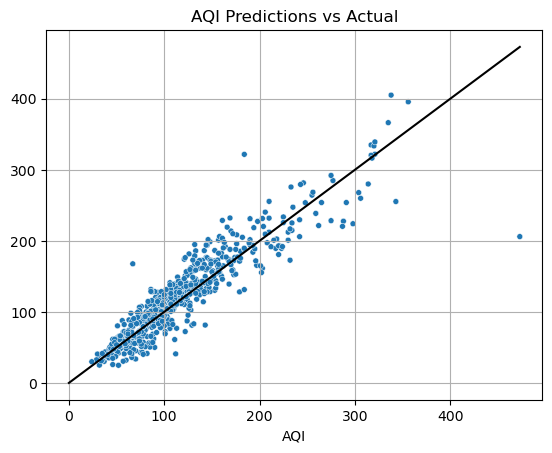

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_best_svr, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

## XGBoost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the XGBoost Regressor with default or manually chosen parameters
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Fit the model on the training data
xgb_model.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Perform cross-validation for MSE and R-squared
xgb_cv_mse = cross_val_score(xgb_model, X, y, cv=5, scoring='neg_mean_squared_error')
xgb_cv_r2 = cross_val_score(xgb_model, X, y, cv=5, scoring='r2')

In [ ]:
# Evaluate the Model
xgb_mse_smoter = mean_squared_error(y_test, y_pred_xgb)
xgb_rmse_smoter = np.sqrt(xgb_mse_smoter)
xgb_r2_smoter = r2_score(y_test, y_pred_xgb)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


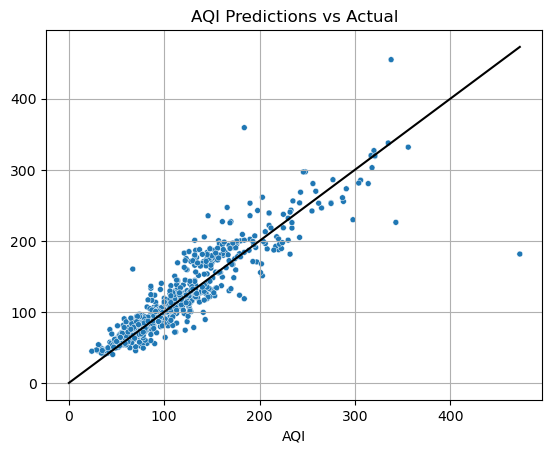

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_xgb, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

### Parameter Tuning using RandomisedSearch

In [ ]:
import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the XGBoost Regressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Define the hyperparameter grid
param_dist = {
    'n_estimators': randint(50, 200),  # Number of trees (estimators)
    'learning_rate': uniform(0.01, 0.3),  # Learning rate (eta)
    'max_depth': randint(3, 10),  # Depth of trees
    'subsample': uniform(0.5, 0.5),  # Subsampling of rows
    'colsample_bytree': uniform(0.5, 0.5),  # Subsampling of columns
    'reg_alpha': uniform(0, 0.1),  # L1 regularization (alpha)
    'reg_lambda': uniform(0.1, 1.0),  # L2 regularization (lambda)
}

# Use RandomizedSearchCV for tuning
random_search_xgb = RandomizedSearchCV(xgb_model, param_distributions=param_dist, 
                                       n_iter=20, cv=5, scoring='neg_mean_squared_error', 
                                       random_state=42, n_jobs=-1)

# Fit the random search model
random_search_xgb.fit(X_resampled, y_resampled)

# Access cross validation results
xgb_results_smoter = random_search_xgb.cv_results_

# Get the best parameters
best_params_xgb = random_search_xgb.best_params_
print(f"Best parameters found: {best_params_xgb}")

# Use the best model to make predictions
best_xgb = random_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)

Best parameters found: {'colsample_bytree': 0.6974407590877849, 'learning_rate': 0.09804645241541143, 'max_depth': 9, 'n_estimators': 188, 'reg_alpha': 0.019884240408880517, 'reg_lambda': 0.81134195274865, 'subsample': 0.8950877702656028}


In [ ]:
# Evaluate the Model
xgb_mse_best_smoter = mean_squared_error(y_test, y_pred_best_xgb)
xgb_rmse_best_smoter = np.sqrt(xgb_mse_best_smoter)
xgb_r2_best_smoter = r2_score(y_test, y_pred_best_xgb)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


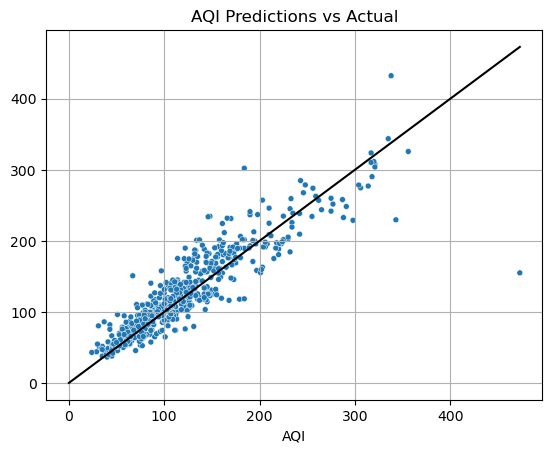

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_best_xgb, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

## Stacked Neural Network + XGBoost

In [ ]:
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import StackingRegressor

# Initialize XGBoost and Neural Network as base learners
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
nn_model = MLPRegressor(hidden_layer_sizes=(50,), activation='relu', solver='adam', max_iter=5000, random_state=42)

# Create the stacking model using Linear Regression as the meta-model
stacked_model = StackingRegressor(
    estimators=[('xgb', xgb_model), ('nn', nn_model)],
    final_estimator=LinearRegression()
)

# Fit the stacked model
stacked_model.fit(X_resampled, y_resampled)

# Make predictions and evaluate the model
y_pred_stacked = stacked_model.predict(X_test)

hybrid_cv = cross_val_score(stacked_model, X, y, cv=5, scoring='neg_mean_squared_error')
hybrid_cv_r2 = cross_val_score(stacked_model, X, y, cv=5, scoring='r2')


In [ ]:
# Evaluate the Model
stacked_mse_smoter = mean_squared_error(y_test, y_pred_stacked)
stacked_rmse_smoter = np.sqrt(stacked_mse_smoter)
stacked_r2_smoter = r2_score(y_test, y_pred_stacked)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


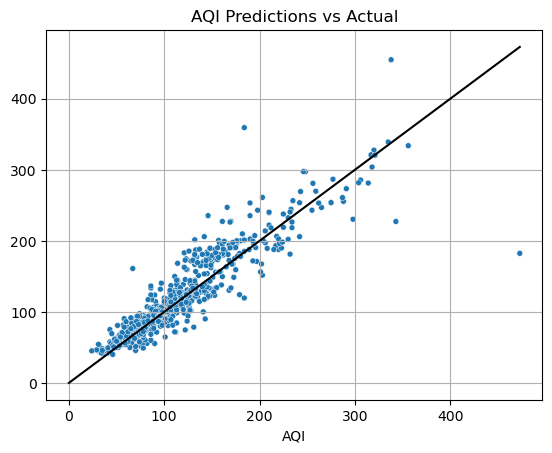

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_stacked, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

### Parameter Tuning using RandomisedSearch

In [ ]:
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import uniform, randint

# Initialize base models
xgb_model = xgb.XGBRegressor(random_state=42)
nn_model = MLPRegressor(max_iter=5000, random_state=42, verbose=False)

# Define the stacking model
stacked_model = StackingRegressor(
    estimators=[('xgb', xgb_model), ('nn', nn_model)],
    final_estimator=LinearRegression()
)

# Define hyperparameter grid for RandomizedSearchCV
param_grid = {
    'xgb__n_estimators': randint(50, 200),
    'xgb__learning_rate': uniform(0.01, 0.3),
    'xgb__max_depth': randint(3, 10),
    'xgb__subsample': uniform(0.5, 0.5),  # Generates values strictly between 0.5 and 1.0
    'xgb__colsample_bytree': uniform(0.5, 0.5),  # Same, strictly between 0.5 and 1.0
    
    'nn__hidden_layer_sizes': [(50,), (100,), (100, 100)],
    'nn__activation': ['relu'],
    'nn__alpha': uniform(0.0001, 0.01),  # Reasonable regularization range
    'nn__solver': ['adam']
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=stacked_model, 
                                   param_distributions=param_grid, 
                                   n_iter=20, 
                                   cv=5, 
                                   scoring='neg_mean_squared_error',
                                   random_state=42, 
                                   n_jobs=1,  # No parallel jobs
                                   error_score='raise')  # Raise errors

# Fit the random search model
random_search.fit(X_resampled, y_resampled)

# Access cross-validation results
stacked_restults_smoter = random_search.cv_results_

# Get the best parameters and best model
best_stacked_model = random_search.best_estimator_
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

# Make predictions and evaluate the tuned stacked model
y_pred_best_stacked = best_stacked_model.predict(X_test)



Best parameters found: {'nn__activation': 'relu', 'nn__alpha': 0.00025636406741193934, 'nn__hidden_layer_sizes': (50,), 'nn__solver': 'adam', 'xgb__colsample_bytree': 0.8861223846483287, 'xgb__learning_rate': 0.06961470446025171, 'xgb__max_depth': 9, 'xgb__n_estimators': 188, 'xgb__subsample': 0.5994212020444025}


In [ ]:
# Evaluate the model
stacked_mse_best_smoter = mean_squared_error(y_test, y_pred_best_stacked)
stacked_rmse_best_smoter = np.sqrt(stacked_mse_best_smoter)
stacked_r2_best_smoter = r2_score(y_test, y_pred_best_stacked)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


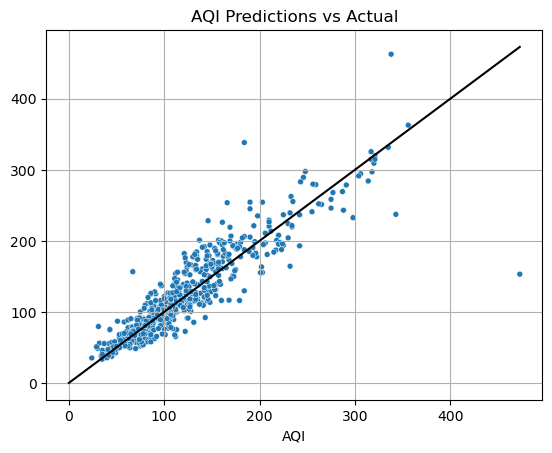

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_best_stacked, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

# Model Comparisons

In [ ]:
from scipy.stats import f_oneway

rf_results_mse_smoter = rf_results_smoter['mean_test_score']
svr_results_mse_smoter = svr_results_smoter['mean_test_score']
xgb_results_mse_smoter = xgb_results_smoter['mean_test_score']
stacked_restults_mse_smoter = stacked_restults_smoter['mean_test_score']

# Perform ANOVA test
f_statistic, p_value = f_oneway(rf_results_mse_smoter, svr_results_mse_smoter, xgb_results_mse_smoter, stacked_restults_mse_smoter)

# Output the results
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

# Interpretation of ANOVA test result
if p_value < 0.05:
    print("There is a statistically significant difference between the models.")
else:
    print("No statistically significant difference between the models.")

F-statistic: 58.48003334654063
P-value: 1.0598369906334405e-19
There is a statistically significant difference between the models.


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Example MSE data for three models
# Replace with your cross-validated MSE data
mse_data = np.concatenate([rf_results_mse_smoter, svr_results_mse_smoter, xgb_results_mse_smoter, stacked_restults_mse_smoter])

# Corresponding labels for the models
model_labels = (['Random Forest'] * len(rf_results_mse_smoter)) + (['SVG'] * len(svr_results_mse_smoter)) + (['XGBoost'] * len(xgb_results_mse_smoter) + (['Hybrid Model'] * len(stacked_restults_mse_smoter)))

# Create a DataFrame to hold the MSE values and corresponding model labels
df = pd.DataFrame({'MSE': mse_data, 'Model': model_labels})

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df['MSE'], groups=df['Model'], alpha=0.05)

# Display the test results
print(tukey)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
    group1        group2     meandiff p-adj    lower     upper   reject
-----------------------------------------------------------------------
 Hybrid Model Random Forest -618.3536    0.0 -790.1197 -446.5874   True
 Hybrid Model           SVG -578.2956    0.0 -750.0617 -406.5294   True
 Hybrid Model       XGBoost   26.3445 0.9777 -145.4217  198.1107  False
Random Forest           SVG    40.058 0.9278 -131.7082  211.8242  False
Random Forest       XGBoost  644.6981    0.0  472.9319  816.4643   True
          SVG       XGBoost  604.6401    0.0  432.8739  776.4063   True
-----------------------------------------------------------------------


In [ ]:
# Dataframe for Metric Comparison without SMOTER

models = ['OLS', 'Random Forest', 'SVR', 'XGB', 'XGB + NN']
mse_smoter = [ols_mse_smoter, rf_mse_best_smoter, svr_mse_best_smoter, xgb_mse_best_smoter, stacked_mse_best_smoter]
rmse_smoter = [ols_rmse_smoter, rf_rmse_best_smoter, svr_rmse_best_smoter, xgb_rmse_best_smoter, stacked_rmse_best_smoter]
r2_smoter = [ols_r2_smoter, rf_r2_best_smoter, svr_r2_best_smoter, xgb_r2_best_smoter, stacked_r2_best_smoter]

# Create the DataFrame
df_results_smoter = pd.DataFrame({
    'Model': models,
    'MSE': mse_smoter,
    'RMSE': rmse_smoter,
    'R²': r2_smoter
})

# Display the DataFrame
df_results_smoter

,Model,MSE,RMSE,R²
0,OLS,703.630363,26.526032,0.813327
1,Random Forest,667.703496,25.839959,0.822859
2,SVR,647.288788,25.441871,0.828275
3,XGB,712.433569,26.691451,0.810992
4,XGB + NN,703.153389,26.517040,0.813454


## Cross Validation Comparison

In [ ]:
X = model_data.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data['AQI']

# Hybrid
stacked_mse_cv_smote = -cross_val_score(best_stacked_model, X, y, cv=5, scoring='neg_mean_squared_error')
stacked_r2_cv_smote = cross_val_score(best_stacked_model, X, y, cv=5, scoring='r2')

# RF
rf_mse_cv_smote = -cross_val_score(best_rf, X, y, cv=5, scoring='neg_mean_squared_error')
rf_r2_cv_smote = cross_val_score(best_rf, X, y, cv=5, scoring='r2')

# SVR
svr_r2_cv_smote = cross_val_score(best_svr, X, y, cv=5, scoring='r2', n_jobs=-1)
svr_mse_cv_smote = -cross_val_score(best_svr, X, y, cv=5, scoring='neg_mean_squared_error')

# XGBoost
xgb_r2_cv_smote = cross_val_score(best_xgb, X, y, cv=5, scoring='r2')
xgb_mse_cv_smote = -cross_val_score(best_xgb, X, y, cv=5, scoring='neg_mean_squared_error')

# Average MSE
avg_mse_smote = [np.mean(stacked_mse_cv),np.mean(rf_mse_cv),np.mean(svr_mse_cv),np.mean(xgb_mse_cv)]

# Average RMSE
avg_rmse_smote = [np.mean(np.sqrt(stacked_mse_cv)),np.mean(np.sqrt(rf_mse_cv)),np.mean(np.sqrt(svr_mse_cv)),np.mean(np.sqrt(xgb_mse_cv))]

# Average R2
avg_r2_smote = [np.mean(stacked_r2_cv),np.mean(rf_r2_cv),np.mean(svr_r2_cv),np.mean(xgb_r2_cv)]

# SMOTE vs Without SMOTE

In [ ]:
# Models (row index)
models = ['Random Forest', 'SVR', 'XGB', 'Hybrid Model']

# Create MultiIndex for columns
multi_column_index = pd.MultiIndex.from_product(
    [['Without SMOTER', 'With SMOTER'], ['MSE', 'RMSE', 'R²']],
    names=['Condition', 'Metric']
)

# Create the DataFrame with hierarchical columns
df_combined_cv = pd.DataFrame({
    ('Without SMOTER', 'MSE'): avg_mse,
    ('Without SMOTER', 'RMSE'): avg_rmse,
    ('Without SMOTER', 'R²'): avg_r2,
    ('With SMOTER', 'MSE'): avg_mse_smote,
    ('With SMOTER', 'RMSE'): avg_rmse_smote,
    ('With SMOTER', 'R²'): avg_r2_smote
}, index=models)

# Display the combined DataFrame
df_combined_cv


Without SMOTER                      With SMOTER             \
                         MSE       RMSE        R²         MSE       RMSE   
OLS               625.747672  25.014949  0.833990  703.630363  26.526032   
Random Forest     555.444372  23.567867  0.852641  667.703496  25.839959   
SVR               634.341530  25.186138  0.831710  647.288788  25.441871   
XGB               660.983964  25.709608  0.824641  712.433569  26.691451   
Hybrid Model      664.459460  25.777111  0.823719  703.153389  26.517040   

                         
                     R²  
OLS            0.813327  
Random Forest  0.822859  
SVR            0.828275  
XGB            0.810992  
Hybrid Model   0.813454

## Cross Validation SMOTER Comparison

In [ ]:
# Models (row index)
models = ['OLS', 'Random Forest', 'SVR', 'XGB', 'Hybrid Model']

# Create MultiIndex for columns
multi_column_index = pd.MultiIndex.from_product(
    [['Without SMOTER', 'With SMOTER'], ['MSE', 'RMSE', 'R²']],
    names=['Condition', 'Metric']
)

# Create the DataFrame with hierarchical columns
df_combined = pd.DataFrame({
    ('Without SMOTER', 'MSE'): mse,
    ('Without SMOTER', 'RMSE'): rmse,
    ('Without SMOTER', 'R²'): r2,
    ('With SMOTER', 'MSE'): mse_smoter,
    ('With SMOTER', 'RMSE'): rmse_smoter,
    ('With SMOTER', 'R²'): r2_smoter
}, index=models)

# Display the combined DataFrame
df_combined


# Addressing Increased MSE

## SMOTE Variations

- Look as Residuals
- Investigate the K nearest neighbours used in SMOTER & Sampling Method

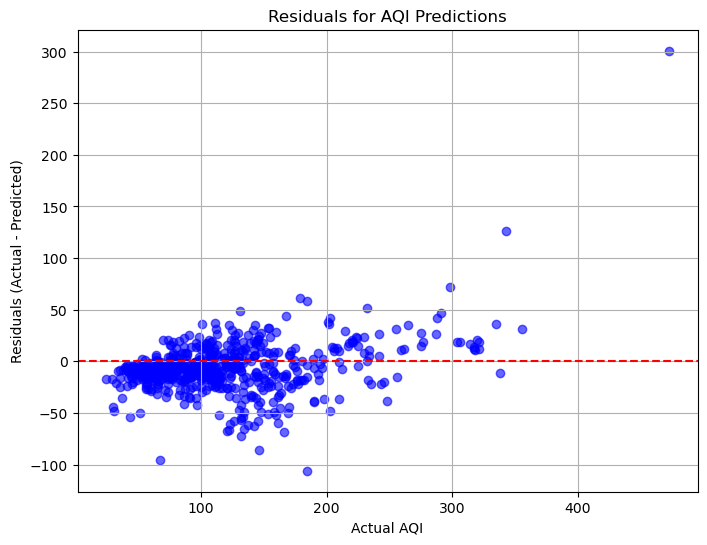

In [ ]:
# Residuals for test data
residuals = y_test - y_pred_best_rf

# Residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual AQI')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals for AQI Predictions')
plt.grid(True)
plt.show()


In [ ]:
X = model_data.drop(['City', 'Date', 'AQI'], axis=1)
y = model_data['AQI']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Resample using higher values K on training set
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

train_resampled = pd.concat([X_train, y_train], axis=1)
train_resampled = smogn.smoter(train_resampled, y='AQI', k=5, samp_method='extreme')

# Split the resampled data back into features and target
X_resampled = train_resampled.drop(columns='AQI', axis=1)
y_resampled = train_resampled['AQI']

r_index: 100%|##########| 134/134 [00:00<00:00, 2888.30it/s]


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='AQI', ylabel='Count'>

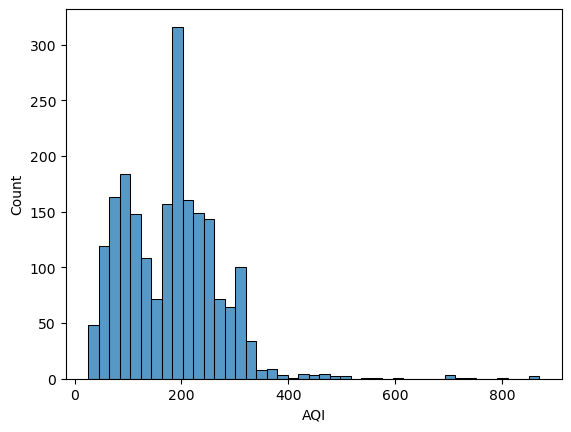

In [ ]:
# Distribution of AQI
sns.histplot(y_resampled)

In [ ]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_dist = {
    'n_estimators': randint(50, 200),  # Random number of trees between 50 and 200
    'max_depth': randint(5, 20),  # Random depth between 5 and 20
    'min_samples_split': randint(2, 10),  # Random min samples for split between 2 and 10
    'min_samples_leaf': randint(1, 10),  # Random min samples at leaf between 1 and 10
    'max_features': ['sqrt', 'log2', None]  # Replace 'auto' with 'sqrt', 'log2', or None
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, 
                                   n_iter=20, cv=5, scoring='neg_mean_squared_error', 
                                   random_state=42, n_jobs=-1)

# Fit the random search model
random_search.fit(X_resampled, y_resampled)

# Access cross val results
rf_results_smoter = random_search.cv_results_

# Get the best parameters
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

# Use the best model to make predictions
best_rf = random_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

Best parameters found: {'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 120}


In [ ]:
# Evaluate the best model
rf_mse_best_smoter = mean_squared_error(y_test, y_pred_best_rf)
rf_rmse_best_smoter = np.sqrt(rf_mse_best_smoter)
rf_r2_best_smoter = r2_score(y_test, y_pred_best_rf)

print(f"Evaluation of the Best Random Forest Model with SMOTER:\n"
      f"MSE: {rf_mse_best_smoter:.2f}\n"
      f"RMSE: {rf_rmse_best_smoter:.2f}\n"
      f"R²: {rf_r2_best_smoter:.4f}")

Evaluation of the Best Random Forest Model with SMOTER:
MSE: 729.44
RMSE: 27.01
R²: 0.8065


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


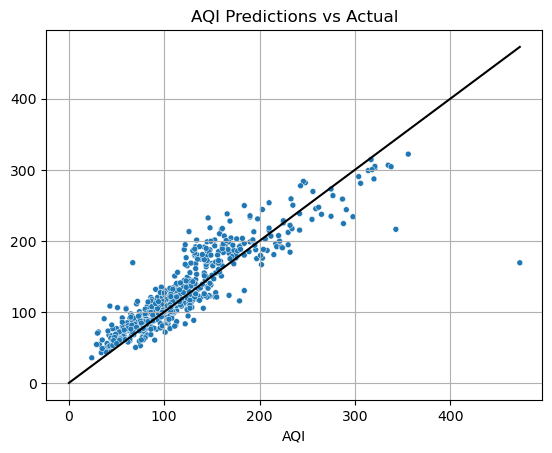

In [ ]:
# Visual plot of y_pred vs y
sns.scatterplot(x=y_test, y=y_pred_best_rf, size=0.05)
sns.lineplot(x=np.linspace(0,max(y_test)),y=np.linspace(0,max(y_test)), color = 'black')
plt.title("AQI Predictions vs Actual")
plt.grid()
plt.legend().remove()

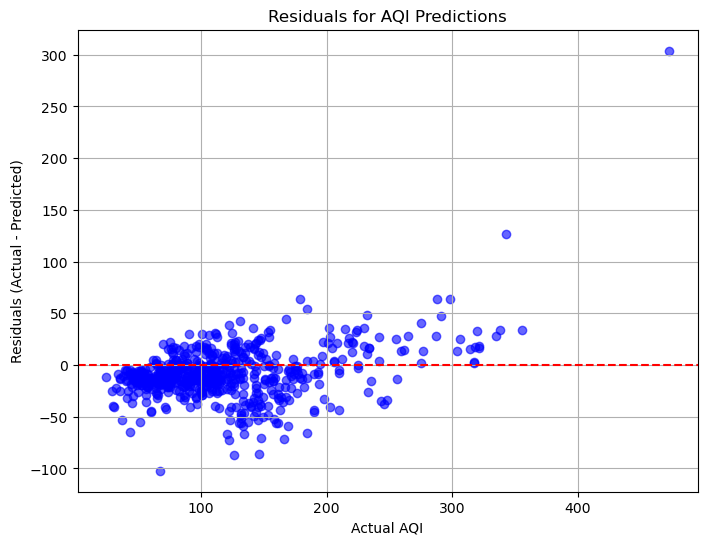

In [ ]:
# Residuals for test data
residuals = y_test - y_pred_best_rf

# Residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual AQI')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals for AQI Predictions')
plt.grid(True)
plt.show()

In [ ]:
# Cross Validate again to check for overfitting
rf_cv = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error')
rf_cv_r2 = cross_val_score(rf, X, y, cv=5, scoring='r2')

print(f"Average MSE {-np.mean(rf_cv)}\n"
      f"Cross Validation R-Square {np.mean(rf_cv_r2)}")

Average MSE 939.4957187411103
Cross Validation R-Square 0.7794630274522565


## Residuals

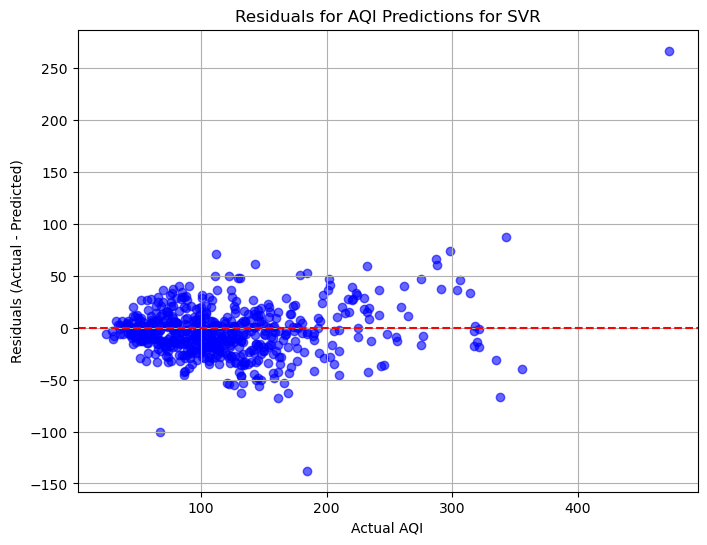

In [ ]:
# Residuals for test data
residuals = y_test - y_pred_best_svr

# Residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual AQI')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals for AQI Predictions for SVR')
plt.grid(True)
plt.show()

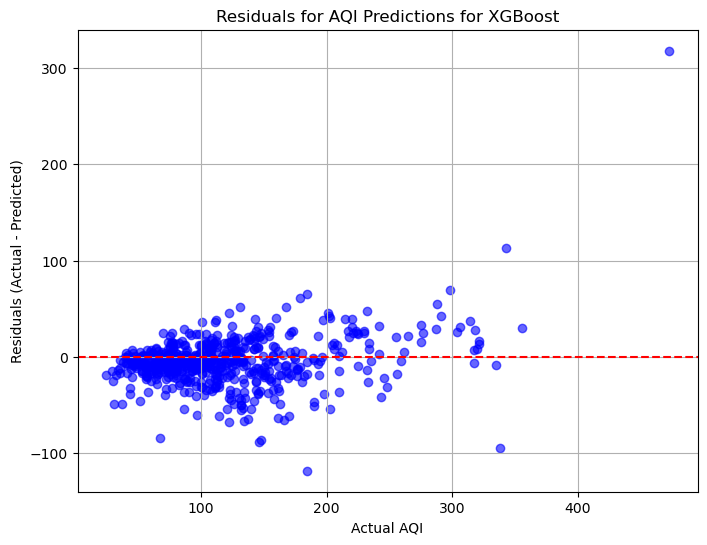

In [ ]:
# Residuals for test data
residuals = y_test - y_pred_best_xgb

# Residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual AQI')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals for AQI Predictions for XGBoost')
plt.grid(True)
plt.show()

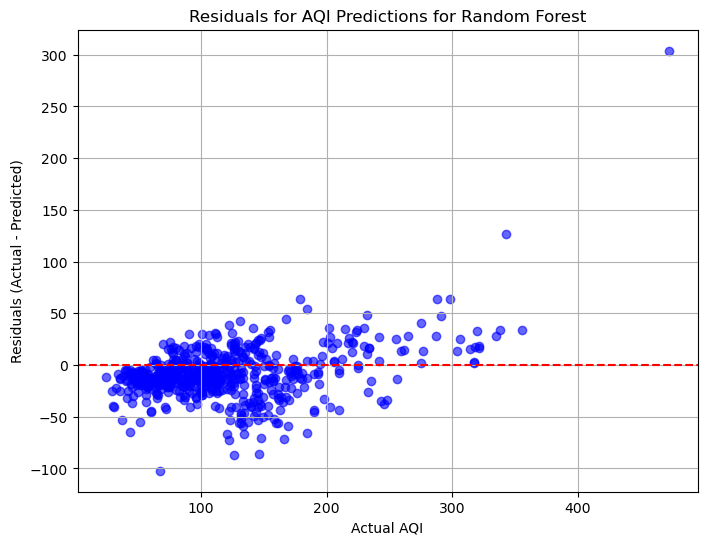

In [ ]:
# Residuals for test data
residuals = y_test - y_pred_best_rf

# Residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual AQI')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals for AQI Predictions for Random Forest')
plt.grid(True)
plt.show()

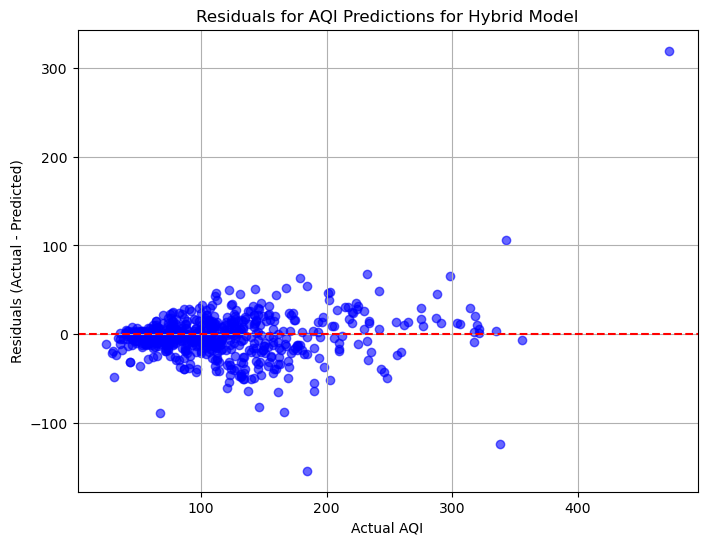

In [ ]:
# Residuals for test data
residuals = y_test - y_pred_best_stacked

# Residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual AQI')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals for AQI Predictions for Hybrid Model')
plt.grid(True)
plt.show()